# Plotting results of predictions

Here, the outputs from `6_combine_ensembles.ipynb` are plotted.




In [1]:
import os
import odc.geo
import numpy as np
import xarray as xr
import geopandas as gpd
# import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from odc.geo.xr import assign_crs
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusEFlux/env/py310/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
# from datacube.utils.dask import start_local_dask
# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

In [3]:
var = 'GPP'
version='v1.2'
results_name = f'AusEFlux_{var}_2003_2022_5km_quantiles_{version}.nc'

base = '/g/data/os22/chad_tmp/AusEFlux/'

### Open predictions

In [4]:
files = [f'{base}results/AusEFlux/{var}/'+i for i in os.listdir(f'{base}results/AusEFlux/{var}/') if i.endswith('.nc')]
files.sort()

ds = xr.open_mfdataset(files).compute()
ds = assign_crs(ds, crs='EPSG:4326')
ds

<xarray.Dataset>
Dimensions:              (time: 240, latitude: 680, longitude: 840)
Coordinates:
    spatial_ref          int32 4326
  * time                 (time) datetime64[ns] 2003-01-15 ... 2022-12-15
  * latitude             (latitude) float32 -10.02 -10.07 ... -43.92 -43.97
  * longitude            (longitude) float32 112.0 112.1 112.1 ... 153.9 154.0
Data variables:
    GPP_5th_percentile   (time, latitude, longitude) float32 nan nan ... nan nan
    GPP_median           (time, latitude, longitude) float32 nan nan ... nan nan
    GPP_95th_percentile  (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    nodata:   nan
    units:    gC/m2/month

## Convert to PgC/year

In [5]:
grid = ds.odc.geobox.to_crs('EPSG:3577')
ds_area = ds.odc.reproject(how=grid, resampling='bilinear')

In [6]:
area_per_pixel = ds_area[var+'_median'].odc.geobox.resolution.x**2

if var != 'ET':
    ds_area = ds_area * area_per_pixel * 1e-15 * 12 # (pgC/year)
else:
    ds_area = ds_area * 12 # (mm/year)

## Zonal timeseries


In [7]:
ds_1D = ds_area[var+'_median'].rename(var).sum(['x','y'])
upper_1D = ds_area[var+'_5th_percentile'].sum(['x','y'])
lower_1D = ds_area[var+'_95th_percentile'].sum(['x','y'])

fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2022.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

if var == 'NEE':
    ds_fire_1d = ds_1D+fire
    ds_fire_1d.drop(['spatial_ref']).to_dataframe(name='NEE+fire')
    

In [8]:
annual_ds = ds_area.resample(time='1Y').sum()
annual_fire = fire.resample(time='1Y').sum()

print('This long-term mean: ', ds_1D.mean().values)

if var=='NEE':
    print('This long-term mean + fire: ', ds_fire_1d.mean().values)
print('This Study IAV (median model): ', (annual_ds[var+'_median'].sum(['x','y']) / 12).std().values)
print('This Study IAV (median model) + FIRE: ',((annual_ds[var+'_median'].sum(['x','y'])+annual_fire)/12).std().values)

ds_clim_mean = ds_area[var+'_median'].groupby('time.month').mean()
print('Seasonal range of '+var, ds_clim_mean.sum(['x','y']).max().values - ds_clim_mean.sum(['x','y']).min().values)

This long-term mean:  4.1300855
This Study IAV (median model):  0.5794455409049988
This Study IAV (median model) + FIRE:  0.5925787091255188
Seasonal range of GPP 1.6617467403411865


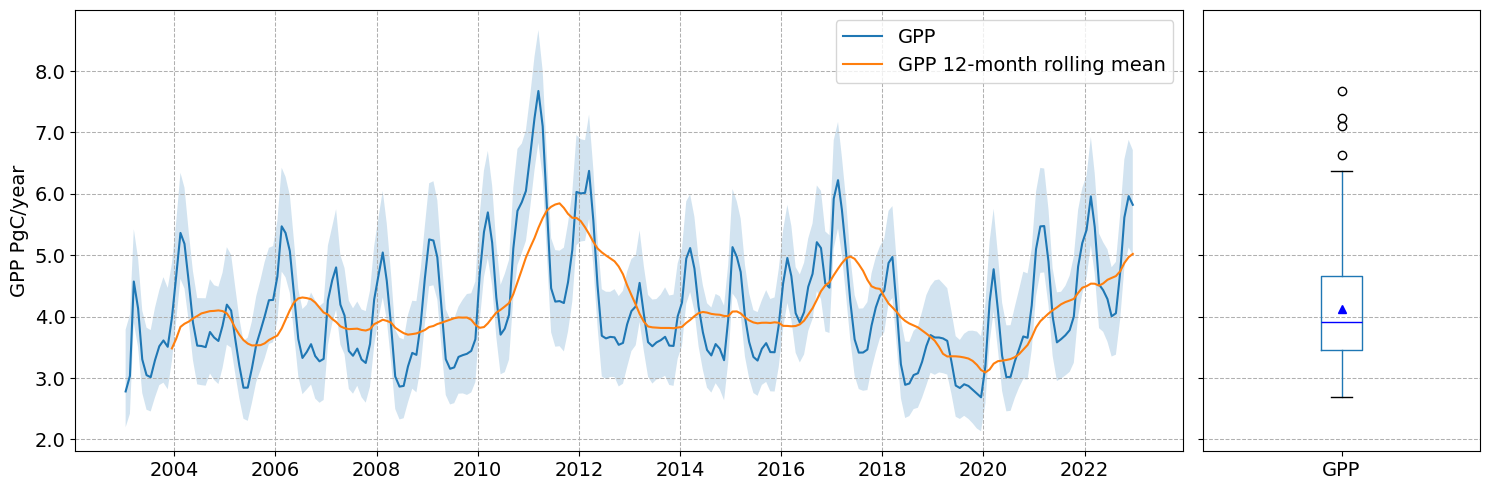

In [9]:
df_1d = ds_1D.drop(['spatial_ref']).to_dataframe()

with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,2, figsize=(15,4), sharey=True, gridspec_kw={'width_ratios': [5, 1]})

if var == 'NEE':
    df_1d['NEE+fire'] = ds_fire_1d.drop(['spatial_ref']).to_dataframe(name='NEE+fire')

ds_1D.plot(linestyle='-', ax=ax[0], label=var)
ds_1D.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label=var+' 12-month rolling mean')
ax[0].fill_between(ds_1D.time, lower_1D, upper_1D, alpha=0.2)
df_1d.boxplot(ax=ax[1], rot=0, grid=False, fontsize=14, showmeans=True, color={'medians': 'blue'}, meanprops={'markerfacecolor': 'blue', 'markeredgecolor':'blue'})

if var == 'NEE':
    
    ds_fire_1d.plot(linestyle='--', ax=ax[0], label='NEE+Fire', c='purple', alpha=0.5)
    ds_fire_1d.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label='NEE+fire 12-month rolling mean')
    ax[0].axhline(0, c='grey', linestyle='--')
    ax[1].axhline(0, c='grey', linestyle='--')
    
if var != 'ET':
    ax[0].set_ylabel(var+' PgC/year', fontsize=14)
else:
    ax[0].set_ylabel(var+' mm/year', fontsize=14)
ax[0].xaxis.set_major_locator(mdates.YearLocator(2))
if var =='ER':
    ax[0].set_ylim(1.0, 8.0)

if var =='NEE':
    ax[0].set_ylim(-2.5, 1.1)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_yticklabels(['{:3.1f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_xlabel('')
ax[0].set_title('')
ax[0].grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
ax[1].grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
ax[0].legend(loc='best', fontsize=14)
plt.tight_layout()

plt.savefig(f'{base}results/figs/{var}_timeseries_with_boxplot_{version}.png', bbox_inches='tight', dpi=300)

## Per-pixel summaries

In [10]:
annual_mean = ds[var+'_median'].resample(time='1Y').sum().mean('time')
annual_std = ds[var+'_median'].resample(time='1Y').sum().std('time')

scaled_variance = annual_std / annual_mean

In [11]:
monthly_mean = ds[var+'_median'].groupby('time.month').mean()

if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')

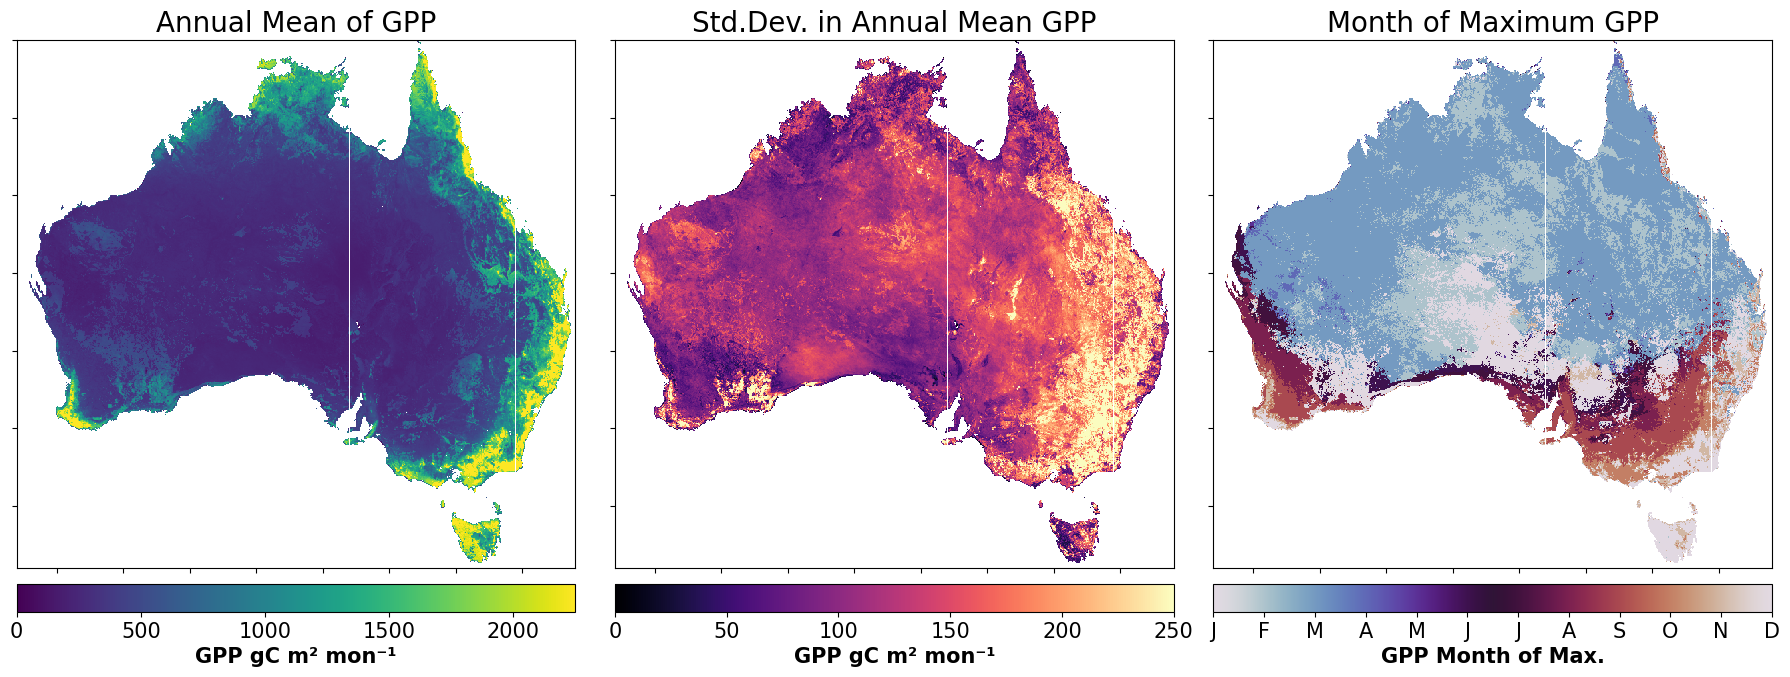

In [16]:
fig,ax = plt.subplots(1,3, figsize=(18,7), sharey=True)
font=20

if var == 'NEE':
    im = annual_mean.rename(var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='RdBu_r',robust=True, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
    # cbar.formatter.set_powerlimits((0, 0))
else:
    im = annual_mean.rename(var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', vmin=0, vmax=2250, add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)

if var=='NEE':
    im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',robust=True, add_colorbar=False, add_labels=False)
else:
    im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma',vmin=0, vmax=250, add_colorbar=False, add_labels=False)

cbar1 = plt.colorbar(im1, location='bottom', pad=0.025, ax=ax[1])
cbar1.set_label(label=var+' gC m\N{SUPERSCRIPT TWO} mon⁻¹', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

im2 = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[2], cmap='twilight', add_colorbar=False, add_labels=False)
cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.025)
cbar2.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar2.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)
cbar2.set_label(label=var+' Month of Max.', size=15, weight='bold')

ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var,fontsize=font)
ax[1].set_title('Std.Dev. in Annual Mean '+var, fontsize=font)

if var=='NEE':
    ax[2].set_title('Month of Maximum Carbon Uptake', fontsize=font);
else:
    ax[2].set_title('Month of Maximum '+var, fontsize=font);
    
plt.tight_layout();
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_perpixel_summaries_'+suffix+'.png')

plt.savefig(f'{base}results/figs/{var}_perpixel_summaries_{version}.png', bbox_inches='tight', dpi=300)

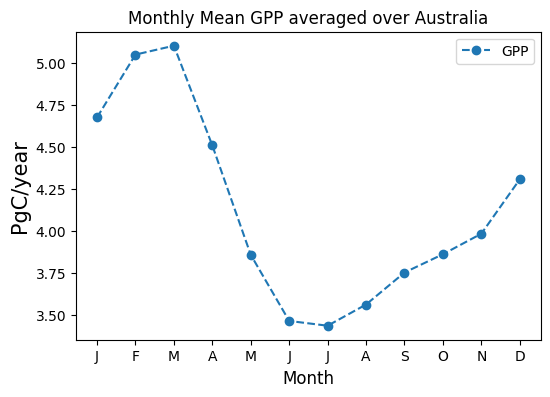

In [17]:
y = ds_area[var+'_median'].groupby('time.month').mean().sum(['x','y']).values
x = monthly_mean.month.values
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(x, y, marker='o', linestyle='--', label=var)
# ax.plot(x, y_fire, marker='o', linestyle='--', label='NEE+fire')
if var=='NEE':
    ax.axhline(0, c='grey', linestyle='--')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.legend()
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
ax.set_xlabel('Month', fontsize=12);
ax.set_ylabel('PgC/year', fontsize=15);
